# Using Convnets for classification of flower images

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow import keras
keras.__version__

'2.11.0'

We'll be using a creative-commons licensed 
[flower photo dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) 
of 3670 images falling into 5 categories:
<pre>
'daisy', 'roses', 'dandelion', 'sunflowers', and 'tulips'
</pre>

Please download the following file:
- [flower_photos.zip](https://drive.google.com/file/d/1pZNVfvi9iJRjS6fXFF3om7pp8Gp-AZtM/view?usp=share_link) (220MB)

If you are running this on Google Colab, upload the zipped file to your Google drive, then mount your Google drive using the following code, and copy the file to the base folder:


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/Teaching/COMP3420/flower_photos.zip . 

We then need to unzip the file:

In [5]:
import zipfile

with zipfile.ZipFile('flower_photos.zip', 'r') as zip_ref:
    zip_ref.extractall()

The images are randomly split
into a training set with 90% data and a
test set with 10% data listed in CSV files:

Training set: [train_set.csv](flower_photos/train_set.csv)
Evaluation set: [eval_set.csv](flower_photos/eval_set.csv)


## A convnet model

Let's try the same convnet model we used for the MNIST dataset, adjusted to a higher resolution and 3 colour channels.

In [6]:
import glob
import os
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = [os.path.basename(l) for l in glob.glob('flower_photos/*') 
               if '.' not in l]

In [7]:
def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

train_dataset = (tf.data.TextLineDataset(
    "flower_photos/train_set.csv").
    map(decode_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "flower_photos/eval_set.csv").
    map(decode_csv)).batch(10)

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models

flowers_model = models.Sequential()
flowers_model.add(layers.Conv2D(filters=32, kernel_size=3, activation="relu", 
                                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
flowers_model.add(layers.MaxPooling2D(pool_size=2))
flowers_model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
flowers_model.add(layers.MaxPooling2D(pool_size=2))
flowers_model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu"))
flowers_model.add(layers.Flatten())
flowers_model.add(layers.Dense(5, activation="softmax"))

flowers_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [9]:
flowers_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 346112)            0

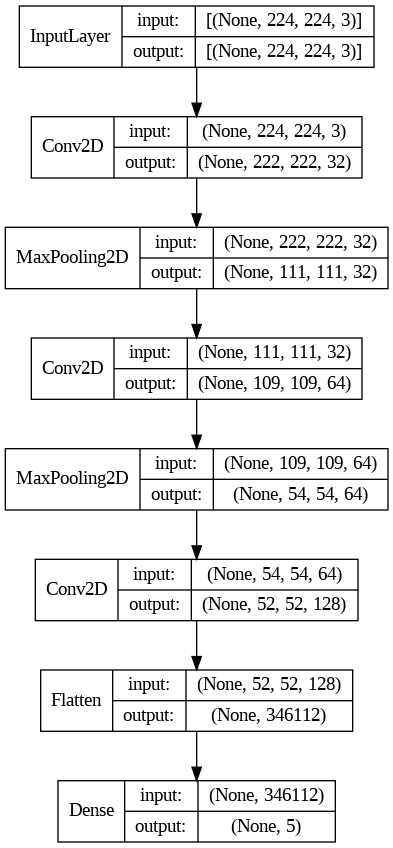

In [10]:
tf.keras.utils.plot_model(flowers_model, show_shapes=True, show_layer_names=False)

In [11]:
history = flowers_model.fit(train_dataset, validation_data=eval_dataset, epochs=10,
                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Epoch 1/10
330/330 [==============================] - 23s 33ms/step - loss: 1.2821 - accuracy: 0.4691 - val_loss: 1.1241 - val_accuracy: 0.5568
Epoch 2/10
330/330 [==============================] - 8s 24ms/step - loss: 0.9885 - accuracy: 0.6170 - val_loss: 1.1981 - val_accuracy: 0.6189


We can see that the accuracy of the eval_test set is 61.89%. This is an increase from the accuracy of 38.11% when we used only a simple dense layer.

# Implementing AlexNet from Scratch

Let's implement AlexNet from scratch and check whether we obtain any improvements. Parts of this code are based on the code samples of Chapter 3 of [Practical Machine Learning for Computer Vision](https://learning.oreilly.com/library/view/practical-machine-learning) and hosted on https://github.com/GoogleCloudPlatform/practical-ml-vision-book.



In [13]:
IMAGE_SIZE = [224, 224] # available image sizes in flowers104 dataset: 512x512, 331x331, 224x224, 192,192
BATCH_SIZE = 64
EPOCHS = 13

alexnet_model = tf.keras.Sequential([
    tf.keras.Input(shape=[*IMAGE_SIZE, 3]),
    # It would be best practice to convert the image from int [0,255] to float [-1,1]
    # format here but this model converges just as well without it.
    tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
    
alexnet_model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']#,
    #steps_per_execution=8
)
alexnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 256)       614656    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 256)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 384)       885120    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 384)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 384)        

This time, we will use a variable learning rate which has proven to be more effective than a fixed learning rate. The following code will set a learning rate that decreases exponentially at every iteration of the training loop, as shown in the plot below.

Learning rate schedule: 0.0001 to 0.0001 to 1.62e-05


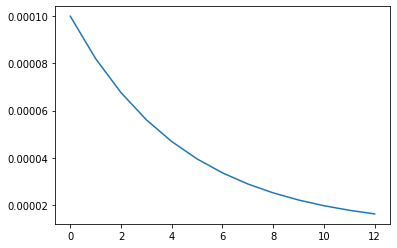

In [14]:
from matplotlib import pyplot as plt

# Learning rate schedule
LR_START = 0.00001
LR_MAX = 0.0001
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

Let's now train the model.

In [15]:
history = alexnet_model.fit(train_dataset, validation_data=eval_dataset, epochs=EPOCHS,
                    callbacks=[lr_callback, tf.keras.callbacks.EarlyStopping(patience=1)])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/13
330/330 [==============================] - 18s 36ms/step - loss: 1.3472 - accuracy: 0.3985 - val_loss: 1.1138 - val_accuracy: 0.5622 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 8.2e-05.
Epoch 2/13
330/330 [==============================] - 13s 41ms/step - loss: 1.0844 - accuracy: 0.5515 - val_loss: 1.0312 - val_accuracy: 0.6108 - lr: 8.2000e-05

Epoch 3: LearningRateScheduler setting learning rate to 6.760000000000002e-05.
Epoch 3/13
330/330 [==============================] - 14s 42ms/step - loss: 0.9212 - accuracy: 0.6442 - val_loss: 0.9845 - val_accuracy: 0.6378 - lr: 6.7600e-05

Epoch 4: LearningRateScheduler setting learning rate to 5.608000000000001e-05.
Epoch 4/13
330/330 [==============================] - 12s 37ms/step - loss: 0.8075 - accuracy: 0.6861 - val_loss: 0.9129 - val_accuracy: 0.6757 - lr: 5.6080e-05

Epoch 5: LearningRateScheduler setting learning rate to 4.686400

Accuracy on the eval set has now increased to 70.81%.